In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as st
from scipy.integrate import odeint
import scipy.integrate as integrate
from scipy.interpolate import interp1d

In [2]:
h_scale = .70
c = 2.99792458e5
w = -1

kind = 'cubic'
GRID_SIZE = 2000

z_begin = .01
z_final = 1.4

# The Berizhiani-Ferreira-Khoury (BFK) model
---
This model describes a universe populated with two interacting superfluid dark matter species. It is goverened by the following equations:
<br>
The Hubble parameter evolves as
$$
    \dot{h}(\tau) = -\frac{3}{2} h^2 \left(\tau \right) + \frac{3}{2}\cos^2 \left( \frac{\tau}{10} \right)
$$
where $h$ is a dimensionless Hubble parameter (and $H_0$ is the Hubble constant)
$$
    h(\tau) \equiv \frac{H(\tau)}{H_0}
$$
and $\tau$ is a dimensionless time value
$$
    \tau \equiv \frac{t}{H_0}.
$$
<br>
The luminosity distance is used to when comparing this model to supernova observations
$$
    d_L = \frac{(1 + z)}{H_0} \int_{t_c}^{t_0} \frac{dt}{a(t_c')}
$$
where $z$ is the redshift, $t_0$ is the cosmic time today, and $a$ is the scale factor. This is used to calculate the distance modulus
$$
    \mu = 5 \log_{10} \left( \frac{d_L}{10 \text{pc}} \right).
$$
<br>
An important value we use to test the model is the CMB shift parameter given by
$$
    \mathcal{R} = \sqrt{\Omega_m} H_0 \int_0^{z_r} \frac{dz'}{h(z)}.
$$

In [3]:
class BFK_Model:
    """Calculates τ, t_c, h, a, z, and ℜ in the BFK_Model model"""
    
    a0 = 1.0               # Current scale factor value
    h0 = 17150             # h = H/H0 initial value

    sec_to_yr = 3600.0*24.0*365.0
    
    
    
    def __init__(self, Ωm, hscale, E, t_cB, h_sol, a_sol_BFK, z_BFK, ℜ, dL_BFKspl, dL_BFKinterp):
        
        self.Ωm = Ωm
        self.hscale = hscale
        
        self.E = E 
        self.t_cB = t_cB
        
        self.h_sol = h_sol
        self.a_sol_BFK = a_sol_BFK
        
        self.z_BFK = z_BFK
        self.ℜ = ℜ
        
        self.dL_BFKspl = dL_BFKspl
        self.dL_BFKinterp = dL_BFKinterp
    
    
    
    def solve_h(self, h, t):
        """Differential equation that gives h(τ) as a solution"""
        return ((-3.0/2.0)*h**2.0 + (3.0/2.0)*np.cos(.5*self.E*t)**2.0)
    
    
    
    def dL_BFK_Model(self):
        """Calculates the luminosity distance dL in the BFK_Model model. 
        Returns a spline of dL and some interpolated values from the spline (used in plotting)"""
        
        def interp_a_spl_BFK_Model(t_cB, a_sol_BFK, kind):
            """Splines cosmic time and scale factor; used in integral of dL"""
            a_spl_BFK  = interp1d(t_cB, a_sol_BFK, kind)
            return a_spl_BFK
        
        
        H0 = 100*self.hscale*3.2407792700054e-20*self.sec_to_yr
        
        
        # Integrand for the luminosity distance integral
        integrand_dL = lambda x : 1.0/(a_spl_BFK(x))
        
        
        a_spl_BFK  = interp_a_spl_BFK_Model(self.t_cB, self.a_sol_BFK, kind)
        
        
        self.dL_BFK = [(1.0 + self.z_BFK[i])*H0*integrate.quad(integrand_dL, 
                                                         self.t_cB[i], 
                                                         self.t_cB[GRID_SIZE - 1])[0] for i in range(GRID_SIZE)]
        
        self.dL_BFKspl = interp1d(self.z_BFK, self.dL_BFK, kind)
        
        
        interp_array = np.linspace(z_begin, z_final, GRID_SIZE, endpoint=True)
        
        for i in range(GRID_SIZE):
            self.dL_BFKinterp[i] = self.dL_BFKspl(interp_array[i])
        
        
        return self.dL_BFKspl, self.dL_BFKinterp
    
    
    
    def run_BFK_Model(self):
        """Calculates the essential parameters in the BFK_Model model"""
        
        def solve_a(a, t):
            """Differential equation for solving for a(t_c)"""
            return a*h_spl(t)
        
        def z_to_h(z):
            """Function that, given a redshift value, returns h; converts z to a and then interpolates h using a"""
            a = 1.0/(1.0 + z)
            return a_h_spl(a)
        
        
        # Shift parameter integrand
        ℜ_int = lambda z : 1.0/z_to_h(z)
        
        
        H0 = 100*self.hscale*3.2407792700054e-20*self.sec_to_yr
        
        # τ is a dimensionless time variable found be dividing cosmic time with H0
        τ0 = 379000*H0
        τf = 1
        τ = np.linspace(τ0, τf, GRID_SIZE, endpoint=True)
        
        
        # We can go back to cosmic time be multiplying by H0
        for i in range(GRID_SIZE): self.t_cB[i] = τ[i]/H0
        t_bw  = np.flipud(self.t_cB)
        
        
        # Integrate the h_dot equation to find 
        h_integ = odeint(self.solve_h, self.h0, τ)[..., 0]
        self.h_sol = h_integ*H0
        h_spl = interp1d(self.t_cB, self.h_sol, kind, fill_value='extrapolate')
        
        
        # Scale Factor (bw='backwards')
        a_sol_bw = odeint(solve_a, self.a0, t_bw)[..., 0]
        self.a_sol_BFK = np.flipud(a_sol_bw)
        
        
        # Redshift Values
        for i in range(GRID_SIZE): self.z_BFK[i] = (1.0/self.a_sol_BFK[i]) - 1.0

            
        a_h_spl = interp1d(self.a_sol_BFK, self.h_sol, kind)

        
        # Shift paramter integration
        z_recomb = 1000.0
        self.ℜ  = np.sqrt(self.Ωm)*H0*integrate.quad(ℜ_int, 0, z_recomb)[0]
        
        
        return self.h_sol, self.t_cB, self.a_sol_BFK, self.z_BFK, self.ℜ

# $\Lambda$CDM Equations
---
The Hubble parameter in the standard $\Lambda$CDM universe is
$$
    H(a) / H_0 = \sqrt{(\Omega_b + \Omega_m) \left(a / a_0 \right)^{-3} + \Omega_r \left(a / a_0 \right)^{-4} + \Omega_\Lambda}.
$$
<br>
Since the model under investigation only considers dark matter, and because we are working at late times, we set the baryonic matter and radiation densities to zero, and the dark matter density to $\Omega_m = .3$. The dark energy density is the remaining density: $\Omega_\Lambda = 1 - \Omega_m$ The above equation simplifies to
$$
    H(x) / H_0 = \sqrt{\Omega_m x^{-3} +  \Omega_\Lambda x^{-3(1 + w)}}.
$$

In [4]:
class ΛCDM:
    """Calulates z and dL in ΛCDM"""
    Ωb = 0                     # Baryonic    density parameter
    Ωm = .3                    # Dark matter density parameter
    Ωr = 0                     # Radiation   density parameter
    ΩΛ = 1.0 - Ωb - Ωm - Ωr    # Dark energy density parameter
    
    
    
    def __init__(self, z_ΛCDM, dL_Λ_spl, dL_empty_spl, dL_vacspl, dL_Λ_interp, dL_empty_interp, dL_vac_interp):
        
        self.z_ΛCDM = z_ΛCDM
        
        self.dL_Λ_spl = dL_Λ_spl
        self.dL_empty_spl = dL_empty_spl
        self.dL_vacspl = dL_vacspl
        
        self.dL_Λ_interp = dL_Λ_interp
        self.dL_empty_interp = dL_empty_interp
        self.dL_vac_interp = dL_vac_interp
        
        
        
    def get_H(self, x): return np.sqrt((self.Ωb + self.Ωm)*x**-3.0 
                                       + self.Ωr*x**-4.0 
                                       + self.ΩΛ*x**(-3.0*(1.0 + w)))
    
    
    
    def dL_ΛCDM(self):
        
        integrand_ΛCDM = lambda x : 1.0/(x**2.0 * self.get_H(x))
        
        
        dL_ΛCDM   = [(1.0 + self.z_ΛCDM[i])
                    *integrate.quad(integrand_ΛCDM, 1.0/(1.0 + self.z_ΛCDM[i]), 1)[0] for i in range(GRID_SIZE)]
        
        dL_empty  = [(self.z_ΛCDM[i] + (self.z_ΛCDM[i]**2.0)/2.0) for i in range(GRID_SIZE)]
        
        dL_vac    = [(self.z_ΛCDM[i] + self.z_ΛCDM[i]**2.0) for i in range(GRID_SIZE)]
        
        self.dL_Λ_spl = interp1d(self.z_ΛCDM, dL_ΛCDM, kind)
        self.dL_empty_spl = interp1d(self.z_ΛCDM, dL_empty, kind)
        self.dL_vacspl = interp1d(self.z_ΛCDM, dL_vac, kind)
        
        
        for i in range(GRID_SIZE):            
            self.dL_Λ_interp[i] = self.dL_Λ_spl(self.z_ΛCDM[i])
            self.dL_empty_interp[i] = self.dL_empty_spl(self.z_ΛCDM[i])
            self.dL_vac_interp[i] = self.dL_vacspl(self.z_ΛCDM[i])
        
        return self.dL_Λ_spl, self.dL_empty_spl, self.dL_vacspl, self.dL_Λ_interp, self.dL_empty_interp, self.dL_vac_interp
    
    
    
    def calc_z_ΛCDM(self):
        
        self.z_ΛCDM = np.linspace(z_begin, z_final, GRID_SIZE, endpoint=True)
        
        return self.z_ΛCDM

# 
---

In [5]:
smplx = [1, 2, 3, 4]
smply = [1, 2, 3, 4]
ini_spl = interp1d(smplx, smply, kind=kind)

n_ΔE = 29
lowE = .01
highE = 2
ΔE = np.linspace(lowE, highE, n_ΔE, endpoint=True)
print('ΔE:', ΔE)
print('Using %s ΔE values.' % n_ΔE)
print('\n')

Ωmlow = .235
Ωmhigh = .283
nΩm = 100
Ωm = np.linspace(Ωmlow, Ωmhigh, nΩm, endpoint=True)
print('Ωm:', Ωm)
print('Using %s Ωm values.' % nΩm)
print('\n')

nH0 = 2
H0low = .65
H0high = .77
hscale = [.7]
print('h0:', hscale)
print('\n')

heatΩmE = np.ndarray(((n_ΔE), len(Ωm), len(hscale),), dtype=np.object)

print('This may take several minutes depending on the resolution.')
print('\n')

for i in range(n_ΔE):
    if ((i%5) == False) or (i == n_ΔE - 1):
        print('ΔE[%s] = %.3f' % (i, ΔE[i]))
    
    for j in range(len(Ωm)):
        for k in range(len(hscale)):
            heatΩmE[i][j][k] = BFK_Model(Ωm[j],
                                         hscale[k], 
                                         ΔE[i], 
                                         t_cB=np.zeros(GRID_SIZE), 
                                         h_sol=np.zeros(GRID_SIZE), 
                                         a_sol_BFK=np.zeros(GRID_SIZE), 
                                         z_BFK=np.zeros(GRID_SIZE), 
                                         ℜ=1, 
                                         dL_BFKspl=ini_spl, 
                                         dL_BFKinterp=np.zeros(GRID_SIZE))
            
            heatΩmE[i][j][k].run_BFK_Model()
            
print(' -- Finished -- ')

ΔE: [0.01       0.08107143 0.15214286 0.22321429 0.29428571 0.36535714
 0.43642857 0.5075     0.57857143 0.64964286 0.72071429 0.79178571
 0.86285714 0.93392857 1.005      1.07607143 1.14714286 1.21821429
 1.28928571 1.36035714 1.43142857 1.5025     1.57357143 1.64464286
 1.71571429 1.78678571 1.85785714 1.92892857 2.        ]
Using 29 ΔE values.


Ωm: [0.235      0.23548485 0.2359697  0.23645455 0.23693939 0.23742424
 0.23790909 0.23839394 0.23887879 0.23936364 0.23984848 0.24033333
 0.24081818 0.24130303 0.24178788 0.24227273 0.24275758 0.24324242
 0.24372727 0.24421212 0.24469697 0.24518182 0.24566667 0.24615152
 0.24663636 0.24712121 0.24760606 0.24809091 0.24857576 0.24906061
 0.24954545 0.2500303  0.25051515 0.251      0.25148485 0.2519697
 0.25245455 0.25293939 0.25342424 0.25390909 0.25439394 0.25487879
 0.25536364 0.25584848 0.25633333 0.25681818 0.25730303 0.25778788
 0.25827273 0.25875758 0.25924242 0.25972727 0.26021212 0.26069697
 0.26118182 0.26166667 0.26215152 0.2626363

In [6]:
for i in range(len(ΔE)):
    
    if ((i%5) == False) or (i == n_ΔE - 1):
        print('ΔE[%s] = %.3f' % (i, ΔE[i]))
    
    heatΩmE[i][0][0].dL_BFK_Model()
    
print(' -- Done with all instances of ΔE dL -- ')

ΔE[0] = 0.010
ΔE[5] = 0.365
ΔE[10] = 0.721
ΔE[15] = 1.076
ΔE[20] = 1.431
ΔE[25] = 1.787
ΔE[28] = 2.000
 -- Done with all instances of ΔE dL -- 


In [7]:
heatplt = np.ndarray(((n_ΔE), len(Ωm), len(hscale),), dtype=np.longdouble).reshape((len(hscale), len(Ωm), (n_ΔE)))

for i in range(len(hscale)):
    for j in range(len(Ωm)):
        for k in range(n_ΔE):
            heatplt[i][j][k] = heatΩmE[k][j][i].ℜ

print(' -- done -- ')

 -- done -- 


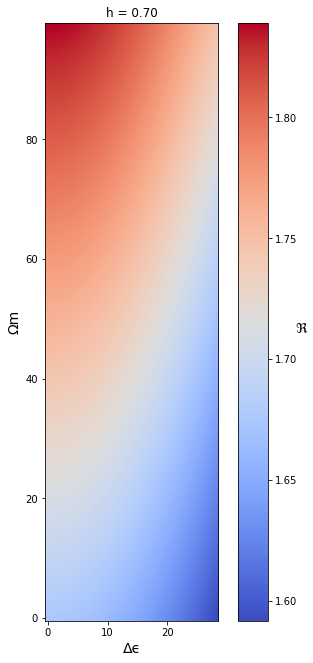

In [8]:
# i = h; j = Ωm; k = ΔE
xgridE = np.zeros(1)
ygridΩ = np.zeros(1)

def get_labels(narr):
    
    ticks = []
    
    for i in range(len(narr)):
        if i % 2 == 0:
            ticks.append(narr[i])
        else:
            ticks.append('')
            
    return ticks

bestdiff = 1000
bestj = 0
bestk = 0

for i in range(len(hscale)):
    plt.figure(figsize = (7, 11))
    plt.title('h = %.2f' % (hscale[i]))
    plt.xlabel('Δϵ', fontsize = 14)
    plt.ylabel('Ωm', fontsize = 14)
    
    fheatplt = plt.imshow(heatplt[i][:][:], cmap = 'coolwarm', interpolation = 'spline16')#,  vmin = 1.68, vmax = 1.74)
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    cb = plt.colorbar(fheatplt)
    cb.set_label('ℜ', fontsize = 14, rotation = 360)
    
    for j in range(len(Ωm)):
        for k in range(len(ΔE)):
            if ((heatplt[i][j][k] <= 1.74) and (heatplt[i][j][k] >= 1.68)):
                diff = abs(heatplt[i][j][k] - 1.71)
                if bestdiff > diff:
                    bestdiff = diff
                    bestj = j
                    bestk = k
                    
plt.show()

In [9]:
# Creates the object associated with ΛCDM values (and empty and vacuum dominated universes)
instCDM = ΛCDM(z_ΛCDM=np.zeros(GRID_SIZE), dL_Λ_spl = ini_spl, dL_empty_spl=ini_spl, dL_vacspl=ini_spl, 
               dL_Λ_interp=np.zeros(GRID_SIZE), dL_empty_interp=np.zeros(GRID_SIZE), dL_vac_interp=np.zeros(GRID_SIZE))

instCDM.calc_z_ΛCDM()
instCDM.dL_ΛCDM()

intR = lambda z : 1.0/math.sqrt(instCDM.Ωm*(1.0 + z)**3.0 + instCDM.ΩΛ)
cdmR = math.sqrt(instCDM.Ωm)*integrate.quad(intR, 0, 1000)[0]

print('ℜ = ', cdmR)
print(' -- done with ΛCDM -- ')

ℜ =  1.7470506313960619
 -- done with ΛCDM -- 


In [10]:
# Opens binned distance modulus supernova data

sn_raw_mod = []
n_rows_mod = 0

with open('jla_likelihood_v6\data\jla_mub.txt', 'r') as reader:
    for line in reader:
        sn_raw_mod.append(line)
        n_rows_mod += 1
        
col_num = 2
s = (n_rows_mod - 1, col_num)
sn_data_mod = np.zeros(s)
zb_mod = np.zeros(n_rows_mod - 1)
μb_mod = np.zeros(n_rows_mod - 1)

for i in range(1, n_rows_mod):
    split = sn_raw_mod[i].split()
    for j in range(col_num):
        sn_data_mod[i - 1][j] = split[j]
        zb_mod[i - 1] = split[0]
        μb_mod[i - 1] = split[1]

print(' -- done loading binned table -- ')

 -- done loading binned table -- 


 -- done resizing -- 
True
 -- done symmetrizing / transposing C matrix -- 


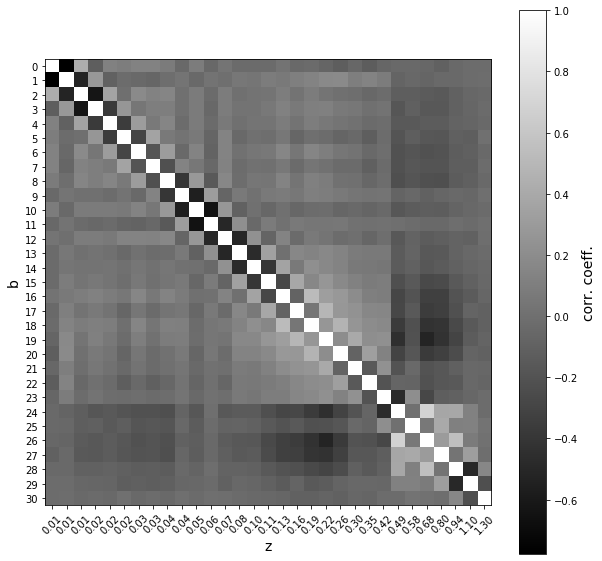

In [19]:
# Creates the convariant matrix of the binned distance modulus and its inverse

def res(d_array): return np.concatenate((np.zeros(dim_row - len(d_array)), d_array), axis=None)

dim_row = 31

C = np.array([
              res([21282, -10840, 1918, 451, 946, 614, 785, 686, 581, 233, 881, 133, 475, 295, 277, 282, 412, 293, 337, 278, 219, 297, 156, 235, 133, 179, -25, -106,   0, 137, 168]),
              res([28155,  -2217, 1702,  74, 322, 380, 273, 424, 487, 266, 303, 406, 468, 447, 398, 464, 403, 455, 468, 417, 444, 351, 399,  83, 167, -86,  15,   -2,  76, 243]),
              res([ 6162,  -1593, 1463, 419, 715, 580, 664, 465, 613, 268, 570, 376, 405, 352, 456, 340, 412, 355, 317, 341, 242, 289, 119, 152, -69, -33, -44,   37, 209]),
              res([ 5235,   -722,  776, 588, 591, 583, 403, 651, 212, 555, 353, 355, 323, 442, 319, 372, 337, 288, 343, 210, 272,  92, 167, -48, -29, -21,  50,  229]),
              res([ 7303,   -508, 1026, 514, 596, 315, 621, 247, 493, 320, 375, 290, 383, 286, 350, 300, 269, 313, 198, 251,  99, 126,  18,  46,  13,  10, 203]),
              res([ 3150,   -249,  800, 431, 358, 414, 173, 514, 231, 248, 221, 293, 187, 245, 198, 175, 231, 126, 210, 103, 170,  51,  66,  -8, -51, 308]),
              res([ 3729,    -88,  730, 321, 592, 188, 546, 316, 342, 290, 389, 267, 341, 285, 252, 301, 189, 242, 122, 159,  35,  72,  30,  28, 255]),
              res([ 3222,   -143,  568, 421, 203, 491, 257, 280, 240, 301, 221, 275, 227, 210, 249, 148, 220, 123, 160,  43,  69,  27,   7, 253]),
              res([ 3225,   -508,  774, 156, 502, 273, 323, 276, 370, 260, 316, 273, 231, 273, 171, 226, 111, 154,   0,  29,  19,  23, 206]),
              res([ 5646,  -1735,  691, 295, 362, 316, 305, 370, 280, 346, 313, 276, 310, 217, 274, 131, 175,  38, 118,  78,  48, 303]),
              res([ 8630,  -1642,  944, 152, 253, 184, 274, 202, 254, 233, 196, 237, 156, 207,  27, 115, -32,   7, -15,   0, 176]),
              res([ 3855,   -754,  502, 225, 278, 294, 274, 285, 253, 239, 255, 173, 229, 181, 177,  93, 124, 132, 108, 227]),
              res([ 4340,   -634,  660, 240, 411, 256, 326, 276, 235, 290, 184, 256, 135, 222,  90, 152,  67,  17, 318]),
              res([ 2986,   -514,  479, 340, 363, 377, 362, 315, 343, 265, 311, 144, 198,  17,  62,  86, 147, 226]),
              res([ 3592,   -134,  606, 333, 422, 374, 333, 349, 267, 300, 157, 184,   9,  71,  85, 136, 202]),
              res([ 1401,     22,  431, 343, 349, 302, 322, 245, 284, 171, 186,  70,  70,  93, 142, 202]),
              res([ 1491,    141,  506, 386, 356, 394, 278, 306, 188, 212,  79,  71, 106, 145, 240]),
              res([ 1203,    200,  435, 331, 379, 281, 311, 184, 209,  49,  51, 110, 197, 181]),
              res([ 1032,    258,  408, 398, 305, 330, 197, 223,  78,  79, 113, 174, 225]),
              res([ 1086,    232,  453, 298, 328, 120, 189, -48,  22,  42, 142, 204]),
              res([ 1006,    151,  329, 282, 169, 195,  58,  80,  95, 192, 188]),
              res([ 1541,    124,  400, 199, 261, 150, 166, 202, 251, 251]),
              res([ 1127,     72,  227, 222,  93, 118,  93, 171, 161]),
              res([ 1723,   -105,  406,  -3, 180, 190, 198, 247]),
              res([ 1550,    144,  946, 502, 647, 437, 215]),
              res([ 1292,    187,  524, 393, 387, 284]),
              res([ 3941,    587, 1657, 641, 346]),
              res([ 2980,    360, 1124, 305]),
              res([ 4465,  -1891,  713]),
              res([23902,  -1826]),
              res([19169])
            ])

C = 1.0e-6 * C

print(' -- done resizing -- ')

for i in range(1, dim_row):
    if i == 1:
        C[1][0] = C[0][1]
    else:
        for j in range(i):
            C[i][j] = C[j][i]
            
C_inv = np.linalg.inv(C)
            
print(np.allclose(np.dot(C_inv, C), np.eye(31)))


print(' -- done symmetrizing / transposing C matrix -- ')

# The distance modulus error bars are the square roots of the diagonal
err = [np.sqrt(C[i][i]) for i in range(dim_row)]


plt.figure(figsize=(10, 10))
dataset = pd.DataFrame(data=C)
corr = dataset.corr()
plt.xticks(ticks = np.arange(len(zb_mod)), labels=[('%.2f' % zb_mod[k]) for k in range(len(zb_mod))], rotation=45)
plt.yticks(ticks = np.arange(len(μb_mod)), labels=[j for j in range(len(μb_mod))])
cm = plt.imshow(corr, cmap='gray', interpolation='nearest')
cb = plt.colorbar(cm)
cb.set_label('corr. coeff.', fontsize=14)
plt.xlabel('z', fontsize=14)
plt.ylabel('b', fontsize=14)
#plt.savefig('cov-matrix', dpi = 150)
plt.show()

ΔE = 0.010 || M = 0.15916  || χ2 = 47.35961
ΔE = 0.081 || M = 0.15916  || χ2 = 47.24899
ΔE = 0.152 || M = 0.15716  || χ2 = 46.96534
ΔE = 0.223 || M = 0.15516  || χ2 = 46.51627
ΔE = 0.294 || M = 0.15215  || χ2 = 45.90912
ΔE = 0.365 || M = 0.14815  || χ2 = 45.15618
ΔE = 0.436 || M = 0.14314  || χ2 = 44.27291
ΔE = 0.508 || M = 0.13814  || χ2 = 43.27708
ΔE = 0.579 || M = 0.13113  || χ2 = 42.18987
ΔE = 0.650 || M = 0.12412  || χ2 = 41.03524
ΔE = 0.721 || M = 0.11612  || χ2 = 39.84255
ΔE = 0.792 || M = 0.10811  || χ2 = 38.64109
ΔE = 0.863 || M = 0.09810  || χ2 = 37.46342
ΔE = 0.934 || M = 0.08809  || χ2 = 36.34559
ΔE = 1.005 || M = 0.07708  || χ2 = 35.32592
ΔE = 1.076 || M = 0.06607 || χ2 = 34.44290
ΔE = 1.147 || M = 0.05405 || χ2 = 33.73966
ΔE = 1.218 || M = 0.04104 || χ2 = 33.25814
ΔE = 1.289 || M = 0.02803 || χ2 = 33.04272
ΔE = 1.360 || M = 0.01401 || χ2 = 33.13667
ΔE = 1.431 || M = 0.00000 || χ2 = 33.58490
ΔE = 1.503 || M = -0.01502 || χ2 = 34.42899
ΔE = 1.574 || M = -0.03003 || χ2 = 35.

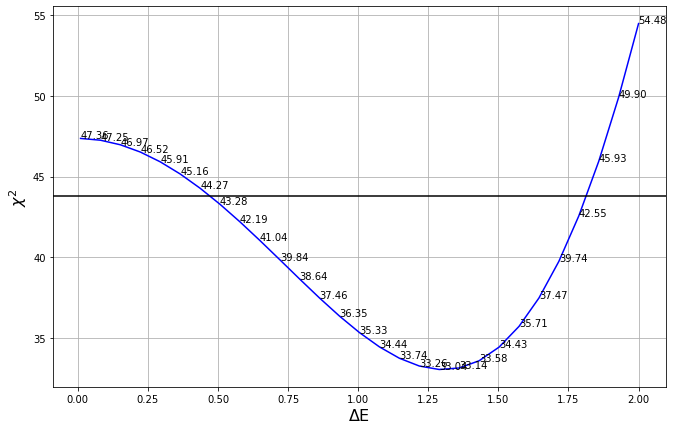

In [12]:
h0 = 100.0*h_scale
convert = c/h0*1.0e6/10.0

def find_M(zb_mod, μb_frm, dL_mat, C_inv):
    
    grid_size = 1000
    χmin_fine_low  = np.zeros(grid_size)
    χmin_fine_high = np.zeros(grid_size)
    
    st = 0
    nd = 1
    
    mmin_fine_low  = np.linspace(st, -nd, num=grid_size, endpoint=True)
    mmin_fine_high = np.linspace(st,  nd, num=grid_size, endpoint=True)
    
    new_m = np.zeros((dim_row, 1))
    
    for j in range(grid_size):
        fine_m = new_m + mmin_fine_low[j]
            
        r_mat = μb_frm - fine_m - dL_mat
        r_dagger_mat = np.transpose(r_mat)
        χmin_fine_low[j] = np.matmul(r_dagger_mat, np.matmul(C_inv, r_mat))
        
        fine_m = new_m + mmin_fine_high[j]
        
        r_mat = μb_frm - fine_m - dL_mat
        r_dagger_mat = np.transpose(r_mat)
        χmin_fine_high[j] = np.matmul(r_dagger_mat, np.matmul(C_inv, r_mat))
        
    χlow_fine = min(χmin_fine_low)
    χhigh_fine = min(χmin_fine_high)
    
    if χlow_fine < χhigh_fine:
        mindex = np.argmin(χmin_fine_low)
        return χlow_fine, mmin_fine_low[mindex]
    elif χhigh_fine < χlow_fine:
        mindex = np.argmin(χmin_fine_high)
        return χhigh_fine, mmin_fine_high[mindex]
    else:
        mindex = np.argmin(χmin_fine_low)
        return χlow_fine, mmin_fine_low[mindex]
    

def χsq_calc(zb_mod, μb_mod, dLtheory, C_inv):
    
    dL_mat = np.zeros((dim_row, 1))
    μb_frm = np.zeros((dim_row, 1))
    
    for i in range(dim_row):
        dL_mat[i] = 5.0*np.log(dLtheory(zb_mod[i])*convert)/np.log(10.0)
        μb_frm[i] = μb_mod[i]
    
    χ2, mmin = find_M(zb_mod, μb_frm, dL_mat, C_inv)   

    return χ2, mmin


def get_model(ind, χsq):
    if ind < len(ΔE):
        return 'ΔE min = %.2f at index %s' % (ΔE[index_min], ind)
    elif ind == len(ΔE):
        return 'ΛCDM, Ωm = %.2f with χ2 = %.2f' % (ΛCDM.Ωm, χsq[ind])
    elif ind == (len(ΔE) + 1):
        return 'an empty universe'
    elif ind == (len(ΔE) + 2):
        return 'a vacuum dominated universe'
    
    
χsq   = np.zeros(len(ΔE) + 3)
M_min = np.zeros(len(ΔE) + 3)


for i in range(len(χsq)):
    if i < len(ΔE):
        #χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, inst[i].dL_BFKspl, C_inv)
        χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, heatΩmE[i][0][0].dL_BFKspl, C_inv)
        if i <= len(ΔE)/2.0:
            print('ΔE = %.3f || M = %.5f  || χ2 = %.5f' % (ΔE[i], M_min[i], χsq[i]))
        else:
            print('ΔE = %.3f || M = %.5f || χ2 = %.5f' % (ΔE[i], M_min[i], χsq[i]))
    elif i == len(ΔE):
        χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, instCDM.dL_Λ_spl, C_inv)
        print('ΛCDM       || M = %.5f  || χ2 = %.5f' % (M_min[i], χsq[i]))
    elif i == (len(ΔE) + 1):
        χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, instCDM.dL_empty_spl, C_inv)
        print('Empty      || M = %.5f  || χ2 = %.5f' % (M_min[i], χsq[i]))
    elif i == (len(ΔE) + 2):
        χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, instCDM.dL_vacspl, C_inv)
        print('Vacuum     || M = %.5f || χ2 = %.5f' % (M_min[i], χsq[i]))
        
        
print('\n')
print('χ2:', χsq)
print('\n')
print('Min of χ2: %.5f' % min(χsq))
print('Min of ΔE χ2: %.5f' % min(χsq[0:len(ΔE)]))
index_min = np.argmin(χsq[:])
index_min_Bb = np.argmin(χsq[0:len(ΔE)])
print('This corresponds to', get_model(index_min, χsq))
print('\n')


signifInd = np.zeros(1)
signifE = np.zeros(1)
setInd = True
print(' ----- Significant models for dof = 30, p<= .05 ----- ')
for i in range(len(ΔE) + 3):
    if χsq[i] <= 43.773:
        
        if i < len(ΔE):
            χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, heatΩmE[i][0][0].dL_BFKspl, C_inv)
            if (setInd):
                signifInd[0] = i
                signifE[0] = ΔE[i]
                setInd = False
            else:
                signifInd = np.append(signifInd, i)
                signifE = np.append(signifE, ΔE[i])
                
            if i <= len(ΔE)/2.0:
                print('ΔE = %.3f || M = %.5f  || χ2 = %.5f' % (ΔE[i], M_min[i], χsq[i]))
            else:
                print('ΔE = %.3f || M = %.5f || χ2 = %.5f' % (ΔE[i], M_min[i], χsq[i]))
        elif i == len(ΔE):
            χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, instCDM.dL_Λ_spl, C_inv)
            print('ΛCDM       || M = %.5f  || χ2 = %.5f' % (M_min[i], χsq[i]))
        elif i == (len(ΔE) + 1):
            χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, instCDM.dL_empty_spl, C_inv)
            print('Empty      || M = %.5f  || χ2 = %.5f' % (M_min[i], χsq[i]))
        elif i == (len(ΔE) + 2):
            χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, instCDM.dL_vacspl, C_inv)
            print('Vacuum     || M = %.5f || χ2 = %.5f' % (M_min[i], χsq[i]))

print('---------------------------------------------------')
print('significant indices:', signifInd)
print(signifE)

plt.figure(figsize=(11, 7))
plt.plot(ΔE, χsq[0:n_ΔE], 'b')
for i, j in zip(ΔE, χsq[:]): plt.annotate('%.2f' % j, xy=(i, j), textcoords='data')
plt.xlabel('ΔE', fontsize=16)
plt.ylabel('$χ^2$', fontsize=16)
plt.axhline(y=43.773, xmin=0, xmax=2, color='k')
plt.grid()
plt.show()

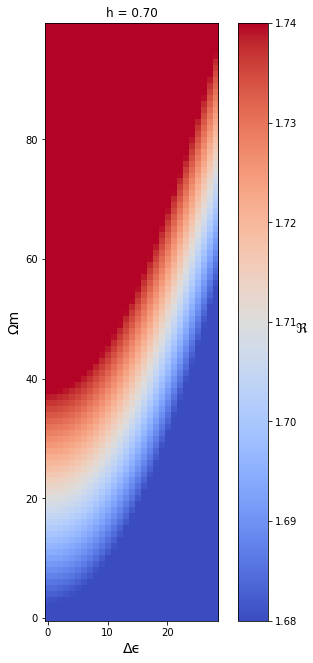

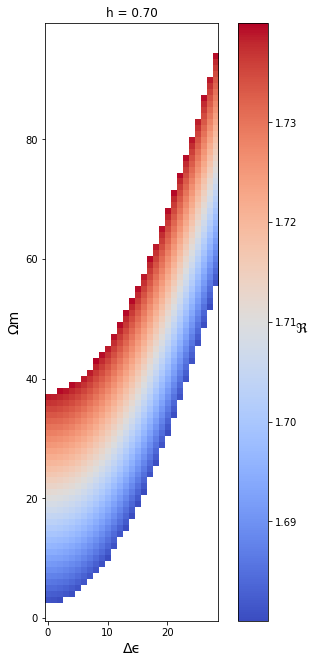

In [18]:
# i = h; j = Ωm; k = ΔE

xgridE = np.zeros(1)
ygridΩ = np.zeros(1)
zgridℜ = np.zeros(1)
statgrid = np.zeros((nΩm, len(ΔE)))
statgrid2 = np.zeros((nΩm, len(ΔE)))
for i in range(len(hscale)):
    plt.figure(figsize = (7, 11))
    plt.title('h = %.2f' % (hscale[i]))
    plt.xlabel('Δϵ', fontsize = 14)
    plt.ylabel('Ωm', fontsize = 14)
    fheatplt = plt.imshow(heatplt[i][:][:], cmap = 'coolwarm', interpolation = 'nearest',  vmin = 1.68, vmax = 1.74)
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    cb = plt.colorbar(fheatplt)
    cb.set_label('ℜ', fontsize = 14, rotation = 360)
    
    for j in range(len(Ωm)):
        for k in range(len(ΔE)):
            if ((heatplt[i][j][k] <= 1.74) and (heatplt[i][j][k] >= 1.68)):
                statgrid[j][k] = heatplt[i][j][k]
                
plt.show()

mask = np.zeros_like(statgrid, dtype=bool)
mask2 = np.zeros_like(statgrid, dtype=bool)

plt.figure(figsize = (7, 11))
plt.title('h = %.2f' % (hscale[i]))
plt.xlabel('Δϵ', fontsize = 14)
plt.ylabel('Ωm', fontsize = 14)

for j in range(len(Ωm)):
    for k in range(len(ΔE)):
        
        if ((heatplt[0][j][k] > 1.74) or (heatplt[0][j][k] < 1.68)):
            mask[j, k] = True
            mask2[j, k] = True
        if k not in signifInd:
            mask2[j, k] = True
            
        if ((heatplt[0][j][k] < 1.74) and (heatplt[0][j][k] > 1.68)):
            diff = abs(heatplt[0][j][k] - 1.71)
            if bestdiff > diff:
                bestdiff = diff
                bestj = j
                bestk = k


statgrid = np.ma.array(statgrid, mask=mask)
statgrid2 = np.ma.array(statgrid2, mask=mask2)
corner_mask = False

fheatpltgrid = plt.imshow(statgrid, cmap='coolwarm', interpolation='nearest')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
cb = plt.colorbar(fheatpltgrid)
cb.set_label('ℜ', fontsize=14, rotation=360)
#plt.savefig('R-ELimit')
plt.show()

In [14]:
x, y = np.meshgrid(ΔE, Ωm)

mskplt = np.ndarray(((n_ΔE), len(Ωm),), dtype = np.longdouble).reshape((len(Ωm), (n_ΔE)))

for j in range(len(Ωm)):
    for k in range(len(ΔE)):      
        if ((heatplt[i][j][k] > 1.74) or (heatplt[i][j][k] < 1.68)):
            mskplt[j][k] = 0
        else:
            mskplt[j][k] = statgrid[j][k]

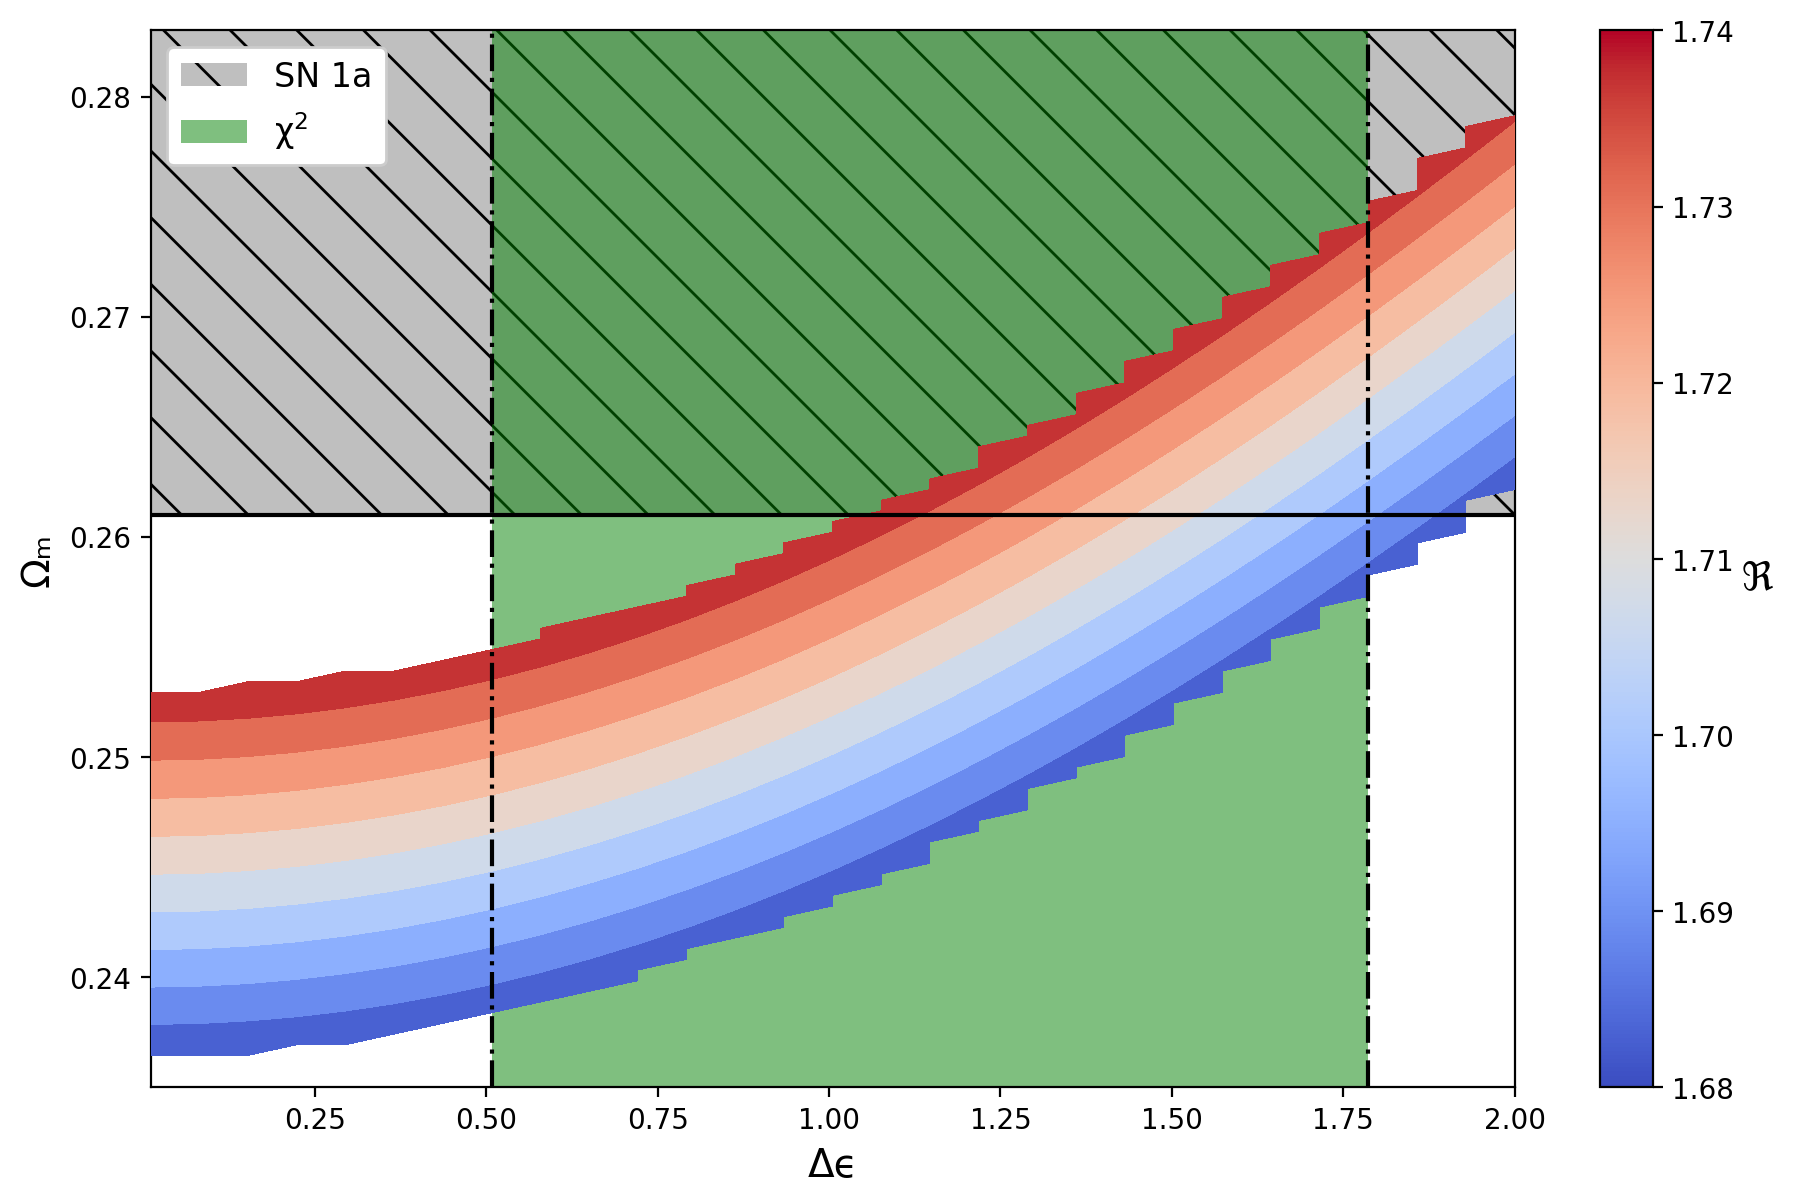

In [15]:
plt.figure(figsize = (11, 7), dpi = 200)

rectangle = plt.Rectangle((0, .261), 2, .034, fc = 'gray', alpha = .5, label = 'SN 1a', hatch = '\\', zorder = 2)#ec = 'black'
plt.gca().add_patch(rectangle)
plt.axhline(y = .261, xmin = 0, xmax = 2, ls = '-', color = 'k', zorder = 5)

rectangle2 = plt.Rectangle((ΔE[int(signifInd[0])], .235), (ΔE[int(signifInd[-1])] - ΔE[int(signifInd[0])]), (Ωm[-1] - Ωm[0]), fc = 'green', alpha = .5, label = 'χ$^2$', zorder = 2.5)# hatch = '/'
plt.gca().add_patch(rectangle2)
plt.axvline(x = ΔE[int(signifInd[0])], ls = '-.', color = 'k', zorder = 5.5)
plt.axvline(x = ΔE[int(signifInd[-1])], ls = '-.', color = 'k', zorder = 6)

plt.contourf(x, y, statgrid, 10, cmap = 'coolwarm', zorder = 3)

cb = plt.colorbar(fheatplt)
cb.set_label('  ℜ', fontsize = 14, rotation = 360)

plt.xlim(ΔE[0], ΔE[-1])
plt.ylim(Ωm[0], Ωm[-1])
plt.xlabel('Δϵ', fontsize = 14)
plt.ylabel('Ωₘ', fontsize = 14)
plt.legend(loc = 'upper left', framealpha = 1, prop = {'size': 12})
#plt.savefig('R-para-space', dpi = 200)
plt.show()

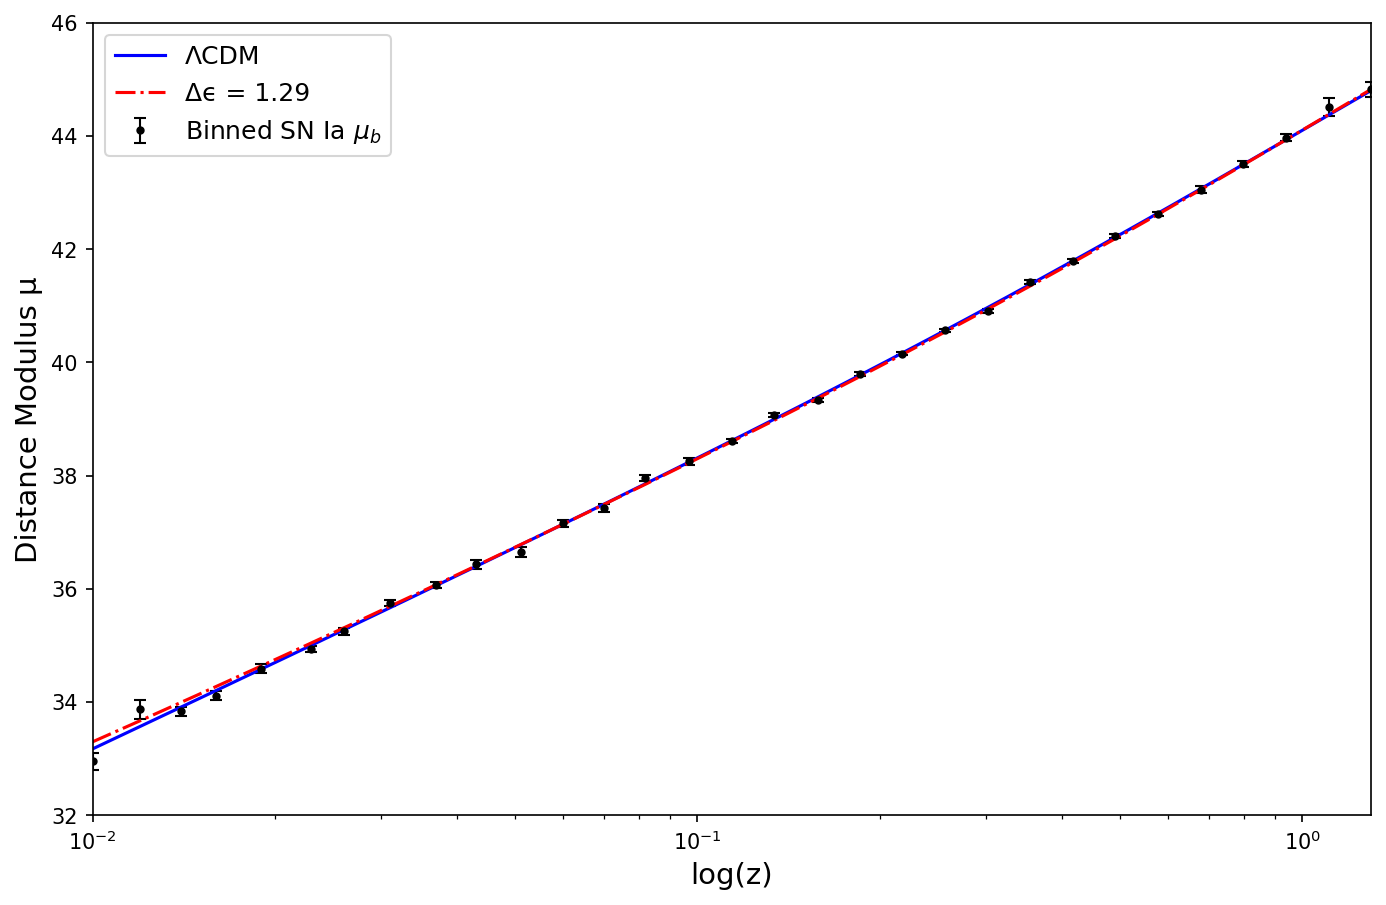

In [16]:
conv_dL_BFK = np.zeros((n_ΔE, GRID_SIZE))
plot_z = np.linspace(z_begin, z_final, GRID_SIZE, endpoint = True)

for i in range(n_ΔE):
    for j in range(1, GRID_SIZE):
        conv_dL_BFK[i][j - 1] = 5.0 * np.log(heatΩmE[i][0][0].dL_BFKinterp[j] * convert) / np.log(10.0)
        
#conv_dLV = np.zeros(GRID_SIZE)
#conv_dLE = np.zeros(GRID_SIZE)
conv_dLΛ = np.zeros(GRID_SIZE)
    
for i in range(GRID_SIZE):
    #conv_dLE[i] = 5.0 * np.log(instCDM.dL_empty_interp[i] * convert) / np.log(10.0)
    #conv_dLV[i] = 5.0 * np.log(instCDM.dL_vac_interp[i] * convert) / np.log(10.0)
    conv_dLΛ[i] = 5.0 * np.log(instCDM.dL_Λ_interp[i]   * convert) / np.log(10.0)
    
plt.figure(figsize = (11, 7), dpi = 150)
plt.errorbar(zb_mod, μb_mod, yerr = err, capsize = 3, elinewidth = 1, color = 'k', fmt = '.', label = 'Binned SN Ia $μ_b$')

plt.plot(plot_z, conv_dLΛ,    'b', label = 'ΛCDM')#, $Ω_m$ = %.3f' % ΛCDM.Ωm)

plt.plot(plot_z, conv_dL_BFK[index_min_Bb][:], 'r-.', label = ('Δϵ = %.2f' % heatΩmE[index_min_Bb][0][0].E))

plt.xlabel('log(z)', fontsize = 14)
plt.ylabel('Distance Modulus μ', fontsize = 14)
plt.xscale('log')
plt.xlim(.01, 1.3)
plt.ylim(32, 46)
plt.legend(loc = 'best', prop = {'size': 12})
#plt.savefig('dL_SN_01-1_no_grid', dpi = 150)
plt.show()

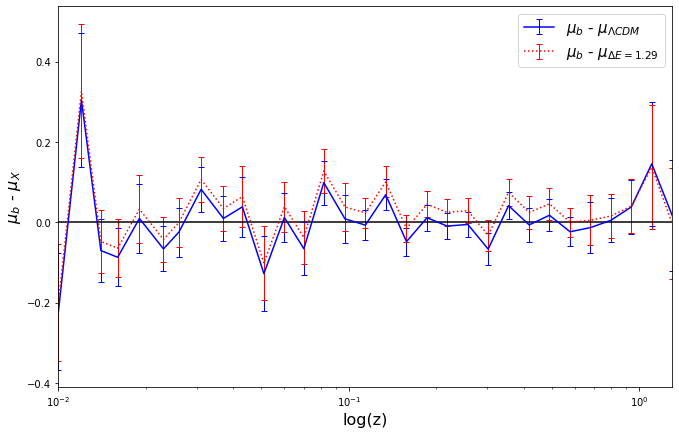

In [17]:
comp_CDM = [5.0 * np.log(instCDM.dL_Λ_spl(zb_mod[i])*convert)
            /np.log(10.0) for i in range(len(μb_mod))]

comp_Bb = [5.0 * np.log(heatΩmE[index_min_Bb][0][0].dL_BFKspl(zb_mod[j])*convert)
           /np.log(10.0) for j in range(len(μb_mod))]

plt.figure(figsize = (11, 7))

plt.plot(zb_mod, [comp_CDM[i] - comp_CDM[i] for i in range(len(comp_CDM))], color='k')

plt.errorbar(zb_mod, [μb_mod[i] - comp_CDM[i] for i in range(len(μb_mod))], 
             yerr=err, color='b', capsize=3, 
             elinewidth=1, label='$μ_b$ - $μ_{ΛCDM}$')

plt.errorbar(zb_mod, [μb_mod[i] - comp_Bb[i] for i in range(len(μb_mod))],  
             yerr=err, ls=':', color='r', capsize=3, elinewidth=1, 
             label=('$μ_b$ - $μ_{ΔE = %.2f}$' % heatΩmE[index_min_Bb][0][0].E))

plt.xscale('log')
plt.xlabel('log(z)', fontsize=16)
plt.ylabel('$μ_b$ - $μ_X$', fontsize=16)
plt.legend(loc='best', prop={'size': 15})
plt.xlim(.01, 1.3)
#plt.savefig('residuals', dpi = 150)
plt.show()